<a href="https://colab.research.google.com/github/I-ULISES-I/Colabfiles/blob/main/ProyectoProgADAP_256056.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Proyecto de Programación para Analítica Descriptiva y Predictiva**
## Nombre del Proyecto: Análisis y Predicción del Riesgo de Cáncer de Tiroides
## Grupo: B
## Autor: Ulises Hernández Rodríguez
## Matrícula: 256056
## Fecha: 10/Mar/25

# **1. Introducción**

## - Descripción del problema: ¿Qué queremos analizar o predecir?

El cáncer de tiroides es un tumor que se origina en la glándula tiroides, una pequeña glándula con forma de mariposa ubicada en el cuello. Es el cáncer endocrinológico más frecuente. El principal síntoma de cáncer de tiroides es un bulto en el cuello. Una pronta detección puede ayudar a prevenir consecuencias irrevertibles, así como un tratamiento temprano.

## - Objetivo del análisis: ¿Qué impacto tendrá este análisis?

El objetivo de este proyecto es analizar las 13 características clínico-patológicas sobre los pacientes que el conjunto de datos proporciona, con la finalidad de intentar predecir el nivel del riesgo que existe de padecer cáncer de tiroides.

## - Fuente de datos: ¿De dónde provienen los datos?

Los datos fueron extraídos de Kaggle del siguiente enlace:
https://www.kaggle.com/datasets/bhargavchirumamilla/thyroid-cancer-risk-dataset, donde se encuentran publicados para que cualquier persona pueda hacer uso de ellos bajo una licencia del MIT.


# **2. Captura y Carga de Datos**

## - Explicación de la fuente de datos: ¿Cuáles son las fuentes de datos?, ¿Qué formato tienen los datos (CSV, SQL, API, etc.)?, ¿Cuántas observaciones y variables contiene el dataset?

El conjunto de datos viene en un archivo con extensión .csv, el cual es un tipo de archivo que contiene información delimitada por comas. A continuacion se presenta una primera vista del formato de la información:

In [ ]:
#Importación de la librerías.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

#Carga del archivo.
df = pd.read_csv('drive/MyDrive/ClassFiles/thyroid_cancer_risk_data.csv')

#Impresión de la información del archivo.
print('Información del archivo:')
print(df.info())

Información del archivo:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212691 entries, 0 to 212690
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Patient_ID           212691 non-null  int64  
 1   Age                  212691 non-null  int64  
 2   Gender               212691 non-null  object 
 3   Country              212691 non-null  object 
 4   Ethnicity            212691 non-null  object 
 5   Family_History       212691 non-null  object 
 6   Radiation_Exposure   212691 non-null  object 
 7   Iodine_Deficiency    212691 non-null  object 
 8   Smoking              212691 non-null  object 
 9   Obesity              212691 non-null  object 
 10  Diabetes             212691 non-null  object 
 11  TSH_Level            212691 non-null  float64
 12  T3_Level             212691 non-null  float64
 13  T4_Level             212691 non-null  float64
 14  Nodule_Size          212691 non-null  float

Como se puede observar, el conjunto presenta un formato estable y formal, cuenta con 17 columnas, las cuales representan los atributos y/o variables, y un total de 212,691 filas sin contar encabezado, los cuales representan la información de cada uno de los pacientes.

## - Explicación sobre problemas en la carga de Datos y el Código para la carga de datos desde archivos (bibiotecas, etc.)

En el momento que se realizó la carga de los datos, no se detectó ni presentó problema alguno.

#**3.Transformación y Preprocesamiento - Data Wrangling**

## - Identificación de Tipos de Datos

In [ ]:
#Impresión de los tipos de datos.
print('Tipos de datos:')
print(df.dtypes)

Tipos de datos:
Patient_ID               int64
Age                      int64
Gender                  object
Country                 object
Ethnicity               object
Family_History          object
Radiation_Exposure      object
Iodine_Deficiency       object
Smoking                 object
Obesity                 object
Diabetes                object
TSH_Level              float64
T3_Level               float64
T4_Level               float64
Nodule_Size            float64
Thyroid_Cancer_Risk     object
Diagnosis               object
dtype: object


## - Cantidad de Valores nulos

Inicialmente, el enlace de donde se obtuvo el conjunto de datos menciona específicamente que no contiene valores nulos, aún así, el siguiente código hace la comprobación de valores nulos.

In [ ]:
#Impresión de la cantidad de los valores nulos.
print('Cantidad de valores nulos:')
print(df.isnull().sum())

Cantidad de valores nulos:
Patient_ID             0
Age                    0
Gender                 0
Country                0
Ethnicity              0
Family_History         0
Radiation_Exposure     0
Iodine_Deficiency      0
Smoking                0
Obesity                0
Diabetes               0
TSH_Level              0
T3_Level               0
T4_Level               0
Nodule_Size            0
Thyroid_Cancer_Risk    0
Diagnosis              0
dtype: int64


##- Explicación sobre cada una de las problemáticas encontradas, las soluciones y el código

En base a los puntos anteriores, el conjunto de datos presenta una estructura limpia en cuanto a su formato, por lo que no fue requerido implementar técnicas de limpieza de datos. Sin embargo, para reducir el consumo de memoria y tener un mejor manejo de la información, varias de las columnas que tienen tipo de dato "object" fuero cambiadas a "category", ya que muchas presentan valores similares.

In [ ]:
#Impresión de los tipos de datos antes del cambio.
print('Tipos de datos y consumo de memoria antes del cambio:')
print(df.info())

#Modificación del tipo de dato.
columnas = ['Gender', 'Country', 'Ethnicity', 'Family_History', 'Radiation_Exposure', 'Iodine_Deficiency', 'Smoking', 'Obesity',
            'Diabetes', 'Thyroid_Cancer_Risk', 'Diagnosis']
df[columnas] = df[columnas].astype('category')

#Impresión de los tipos de datos después del cambio.
print('\nTipos de datos y consumo de memoria después del cambio:')
print(df.info())

Tipos de datos y consumo de memoria antes del cambio:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212691 entries, 0 to 212690
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Patient_ID           212691 non-null  int64  
 1   Age                  212691 non-null  int64  
 2   Gender               212691 non-null  object 
 3   Country              212691 non-null  object 
 4   Ethnicity            212691 non-null  object 
 5   Family_History       212691 non-null  object 
 6   Radiation_Exposure   212691 non-null  object 
 7   Iodine_Deficiency    212691 non-null  object 
 8   Smoking              212691 non-null  object 
 9   Obesity              212691 non-null  object 
 10  Diabetes             212691 non-null  object 
 11  TSH_Level            212691 non-null  float64
 12  T3_Level             212691 non-null  float64
 13  T4_Level             212691 non-null  float64
 14  Nodule_Size   

# **4. Análisis Descriptivo de Datos**

## - Preguntas a responder con el AD
## - Explicación de Estadísticas Básicas Aplicadas, Visualización de Datos con Gráficos, y Resumen de las respuestas

In [ ]:
#Impresión de las estadísticas descriptivas.
print('\nEstadísticas descriptivas:')
print(df.describe())

#Impresión de la moda.
print('\nModa:')
print(df.mode().iloc[0])


Estadísticas descriptivas:
                 Age      TSH_Level       T3_Level       T4_Level  \
count  212691.000000  212691.000000  212691.000000  212691.000000   
mean       51.918497       5.045102       2.001727       8.246204   
std        21.632815       2.860264       0.866248       2.164188   
min        15.000000       0.100000       0.500000       4.500000   
25%        33.000000       2.570000       1.250000       6.370000   
50%        52.000000       5.040000       2.000000       8.240000   
75%        71.000000       7.520000       2.750000      10.120000   
max        89.000000      10.000000       3.500000      12.000000   

         Nodule_Size  
count  212691.000000  
mean        2.503403  
std         1.444631  
min         0.000000  
25%         1.250000  
50%         2.510000  
75%         3.760000  
max         5.000000  

Moda:
Age                         72.0
Gender                    Female
Ethnicity              Caucasian
Family_History                No
Radi

# **5. Análisis Exploratorio de los Datos**

## - Preguntas a responder
## - Estadísticas Empleadas, visualización y Resumen de las respuestas encontradas.

In [ ]:
df = df.drop(columns=['Patient_ID', 'Country', 'Diagnosis'])
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212691 entries, 0 to 212690
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   Age                  212691 non-null  int64   
 1   Gender               212691 non-null  category
 2   Ethnicity            212691 non-null  category
 3   Family_History       212691 non-null  category
 4   Radiation_Exposure   212691 non-null  category
 5   Iodine_Deficiency    212691 non-null  category
 6   Smoking              212691 non-null  category
 7   Obesity              212691 non-null  category
 8   Diabetes             212691 non-null  category
 9   TSH_Level            212691 non-null  float64 
 10  T3_Level             212691 non-null  float64 
 11  T4_Level             212691 non-null  float64 
 12  Nodule_Size          212691 non-null  float64 
 13  Thyroid_Cancer_Risk  212691 non-null  category
dtypes: category(9), float64(4), int64(1)
memory usage: 9

In [ ]:
df.duplicated(keep=False).sum()

np.int64(0)

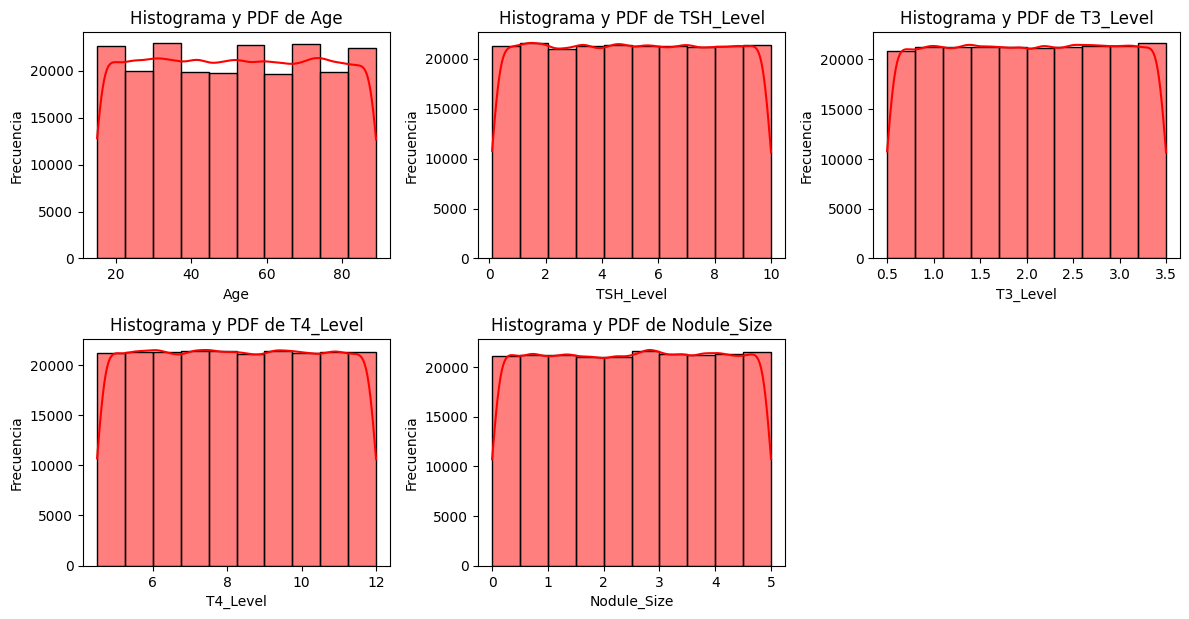

In [ ]:
#Selección de las columnas númericas.
columnas_numericas = df.select_dtypes(include=['int64', 'float64']).columns

#Creación y diseño de los histogramas.
plt.figure(figsize=(12, 12))
for i, columna in enumerate(columnas_numericas, 1):
  plt.subplot(4, 3, i)
  sns.histplot(df[columna], kde=True, bins=10, color='red')
  plt.title(f'Histograma y PDF de {columna}')
  plt.xlabel(columna)
  plt.ylabel('Frecuencia')

#Impresión de los gráficos.
plt.tight_layout()
plt.show()

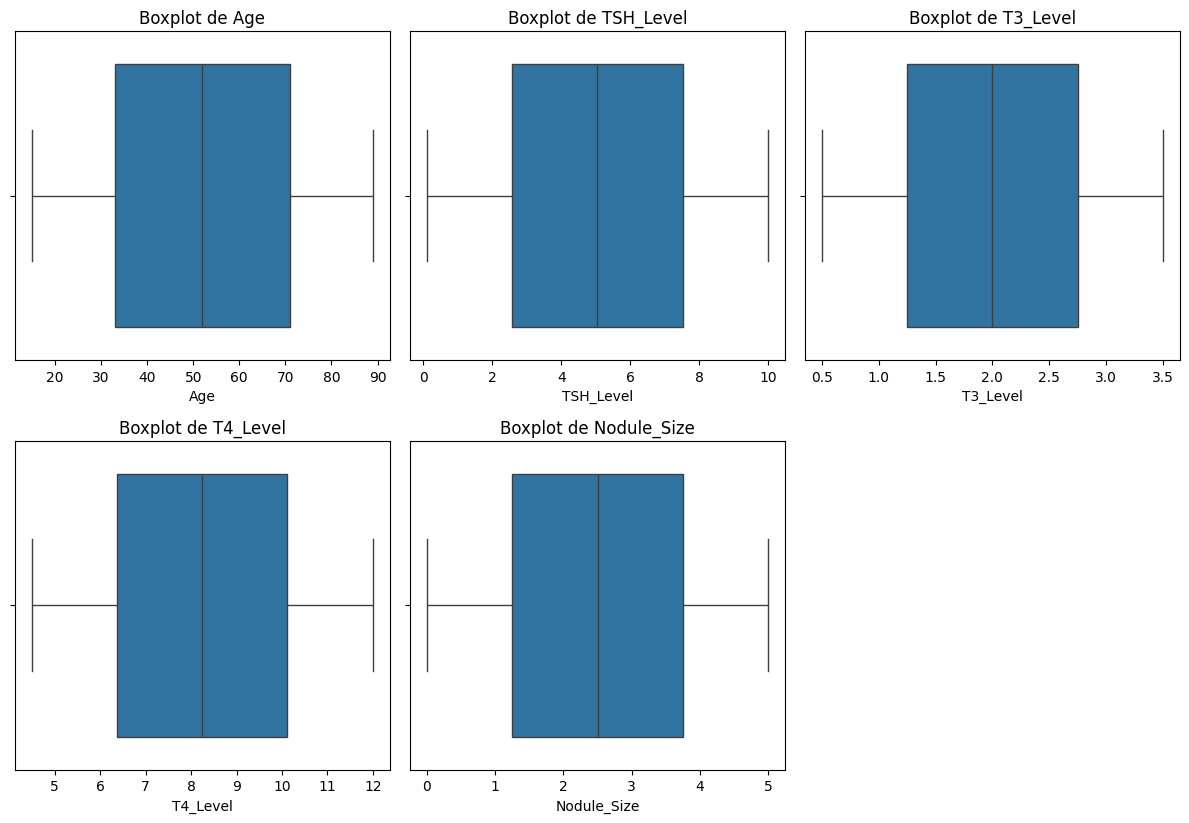

In [ ]:
#Creación y diseño de los boxplots.
plt.figure(figsize=(12, 12))
for i, columna in enumerate(columnas_numericas, 1):
  plt.subplot(3, 3, i)
  sns.boxplot(x=df[columna])
  plt.title(f'Boxplot de {columna}')

#Impresión de los gráficos.
plt.tight_layout()
plt.show()

Matriz de correlación:
                  Age  TSH_Level  T3_Level  T4_Level  Nodule_Size
Age          1.000000  -0.000925 -0.001013 -0.002373    -0.001489
TSH_Level   -0.000925   1.000000  0.000335 -0.000795     0.000416
T3_Level    -0.001013   0.000335  1.000000 -0.004069    -0.001799
T4_Level    -0.002373  -0.000795 -0.004069  1.000000    -0.001860
Nodule_Size -0.001489   0.000416 -0.001799 -0.001860     1.000000


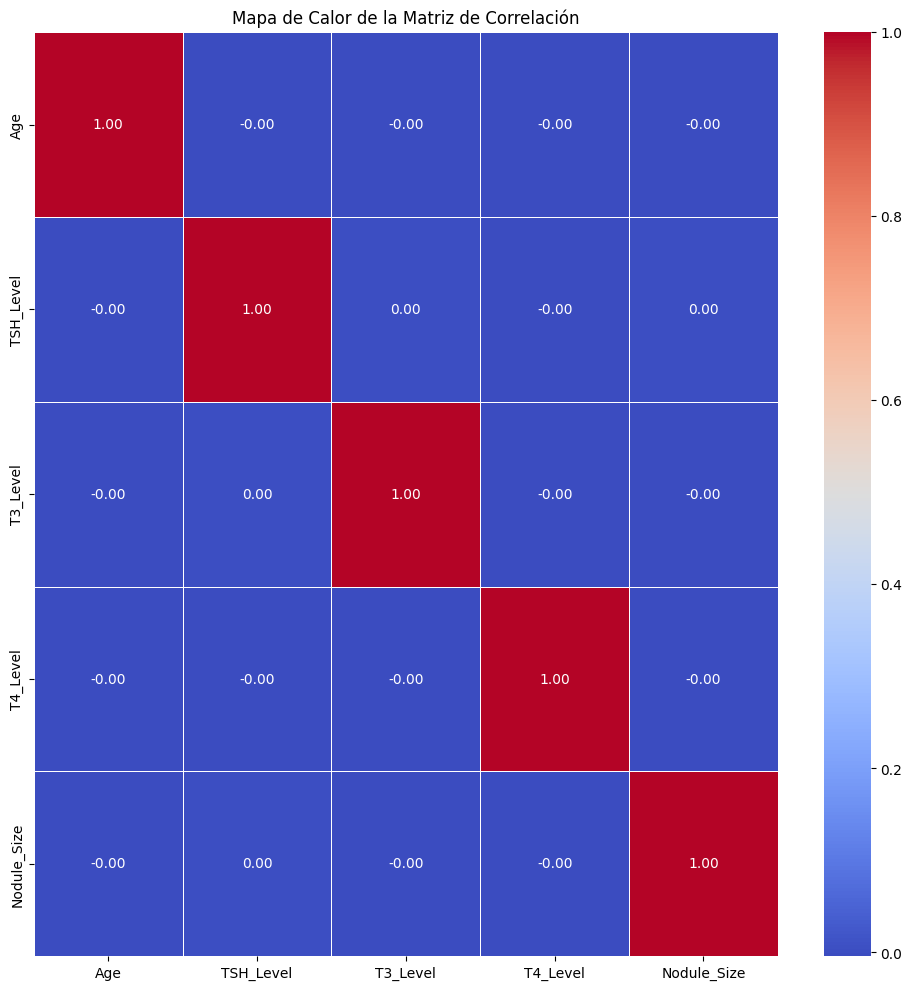

In [ ]:
#Cálculo de la matriz de correlación.
matriz_correlacion = df[columnas_numericas].corr()

#Impresión de la matriz.
print('Matriz de correlación:')
print(matriz_correlacion)

#Creación y diseño del mapa de calor.
plt.figure(figsize=(12, 12))
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Mapa de Calor de la Matriz de Correlación')

#Impresión del gráfico.
plt.show()

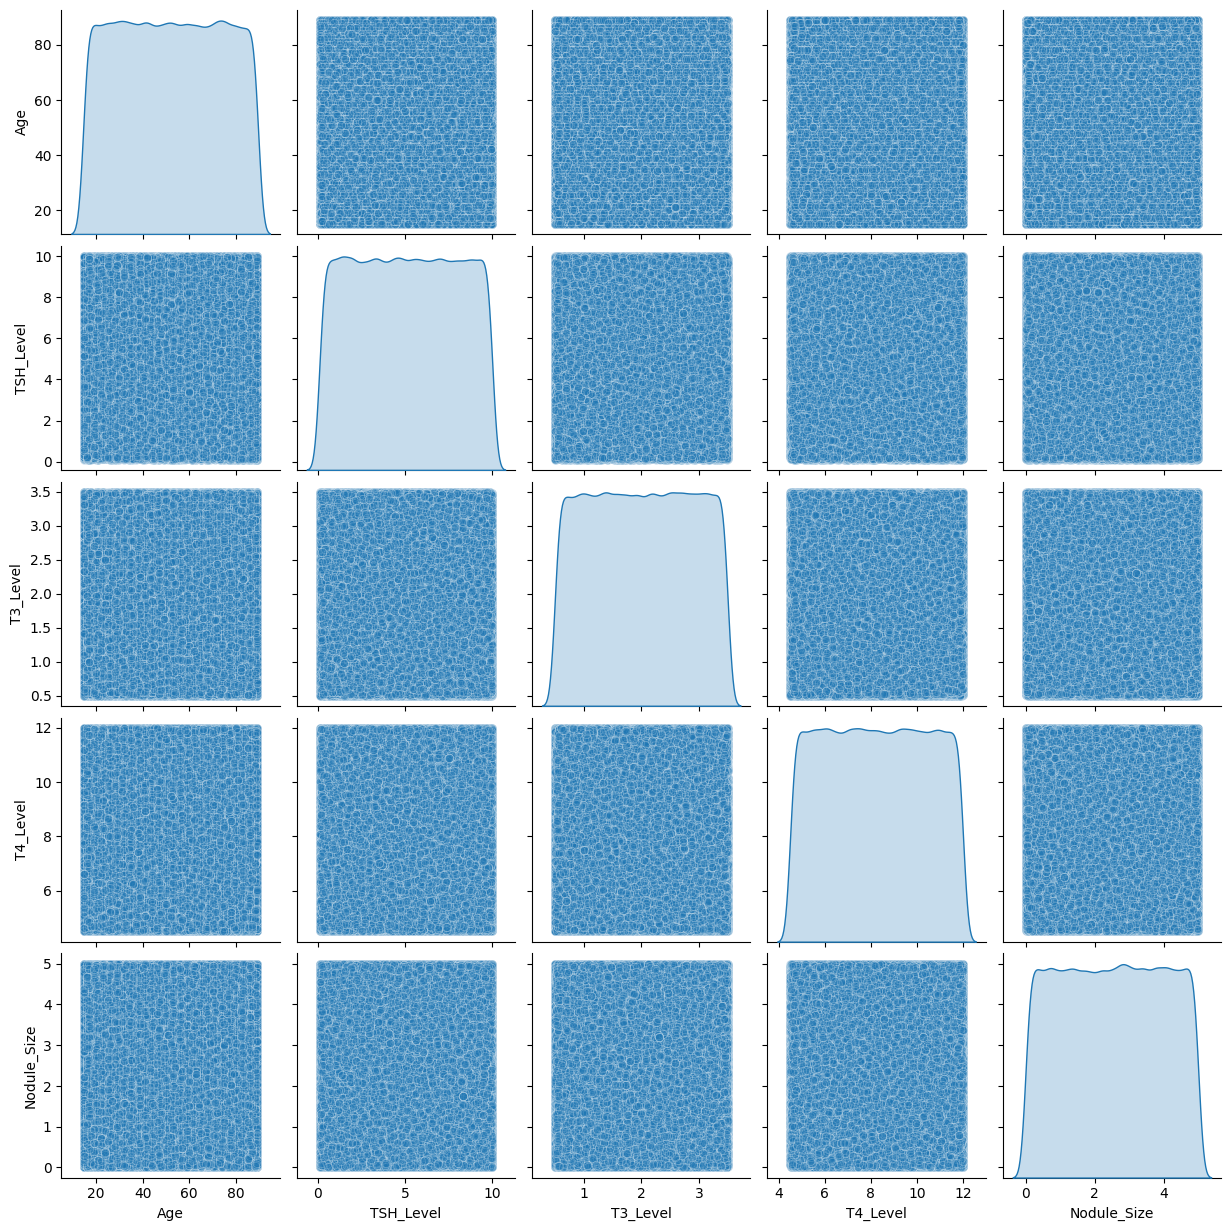

In [ ]:
#Creación y diseño del pairplot.
sns.pairplot(df[columnas_numericas], plot_kws={'alpha': 0.3}, diag_kind='kde')

#Impresión del gráfico.
plt.show()

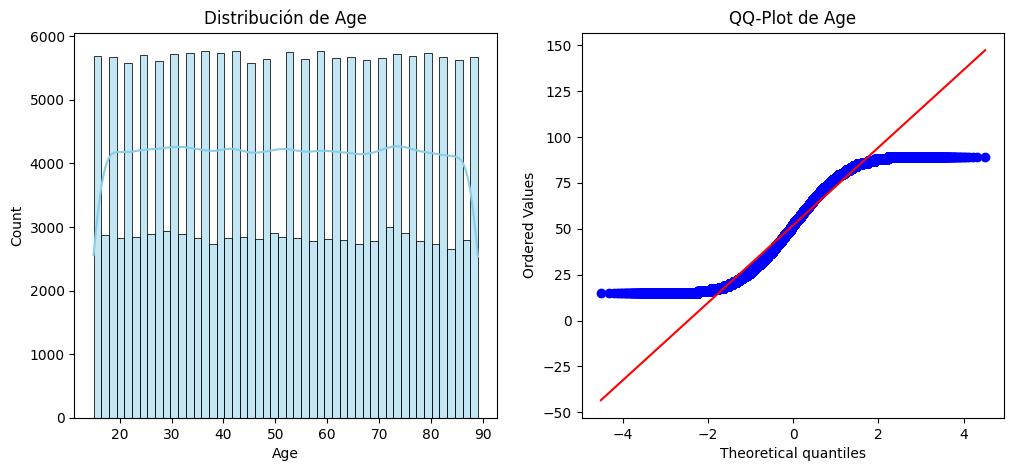


Pruebas de normalidad para: Age
Shapiro-Wilk Test: p-valor = 0.00000
Kolmogorov-Smirnov Test: p-valor = 0.00000
Anderson-Darling Test: Estadístico = 2389.51852
  Al nivel de significancia 15.0%, los datos NO parecen normales.
  Al nivel de significancia 10.0%, los datos NO parecen normales.
  Al nivel de significancia 5.0%, los datos NO parecen normales.
  Al nivel de significancia 2.5%, los datos NO parecen normales.
  Al nivel de significancia 1.0%, los datos NO parecen normales.
D'Agostino-Pearson Test: p-valor = 0.00000


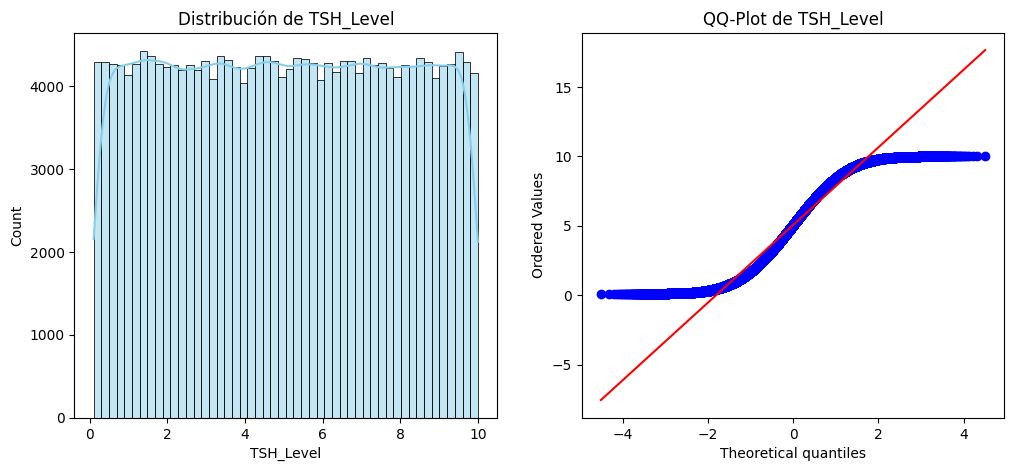


Pruebas de normalidad para: TSH_Level
Shapiro-Wilk Test: p-valor = 0.00000
Kolmogorov-Smirnov Test: p-valor = 0.00000
Anderson-Darling Test: Estadístico = 2372.56778
  Al nivel de significancia 15.0%, los datos NO parecen normales.
  Al nivel de significancia 10.0%, los datos NO parecen normales.
  Al nivel de significancia 5.0%, los datos NO parecen normales.
  Al nivel de significancia 2.5%, los datos NO parecen normales.
  Al nivel de significancia 1.0%, los datos NO parecen normales.
D'Agostino-Pearson Test: p-valor = 0.00000


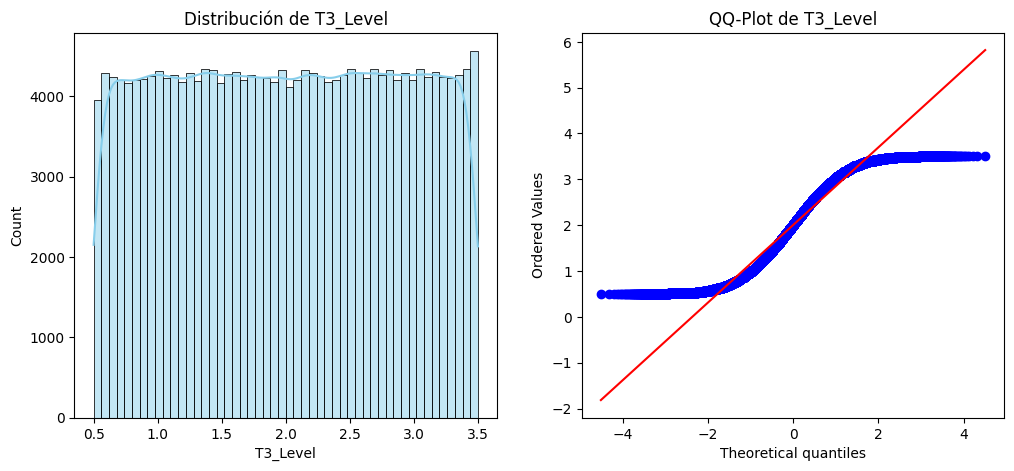


Pruebas de normalidad para: T3_Level
Shapiro-Wilk Test: p-valor = 0.00000
Kolmogorov-Smirnov Test: p-valor = 0.00000
Anderson-Darling Test: Estadístico = 2370.86087
  Al nivel de significancia 15.0%, los datos NO parecen normales.
  Al nivel de significancia 10.0%, los datos NO parecen normales.
  Al nivel de significancia 5.0%, los datos NO parecen normales.
  Al nivel de significancia 2.5%, los datos NO parecen normales.
  Al nivel de significancia 1.0%, los datos NO parecen normales.
D'Agostino-Pearson Test: p-valor = 0.00000


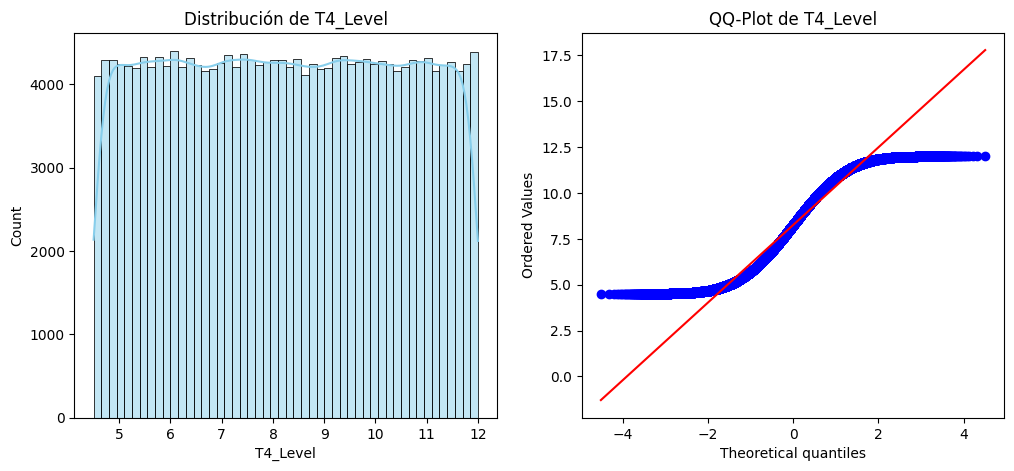


Pruebas de normalidad para: T4_Level
Shapiro-Wilk Test: p-valor = 0.00000
Kolmogorov-Smirnov Test: p-valor = 0.00000
Anderson-Darling Test: Estadístico = 2359.98230
  Al nivel de significancia 15.0%, los datos NO parecen normales.
  Al nivel de significancia 10.0%, los datos NO parecen normales.
  Al nivel de significancia 5.0%, los datos NO parecen normales.
  Al nivel de significancia 2.5%, los datos NO parecen normales.
  Al nivel de significancia 1.0%, los datos NO parecen normales.
D'Agostino-Pearson Test: p-valor = 0.00000


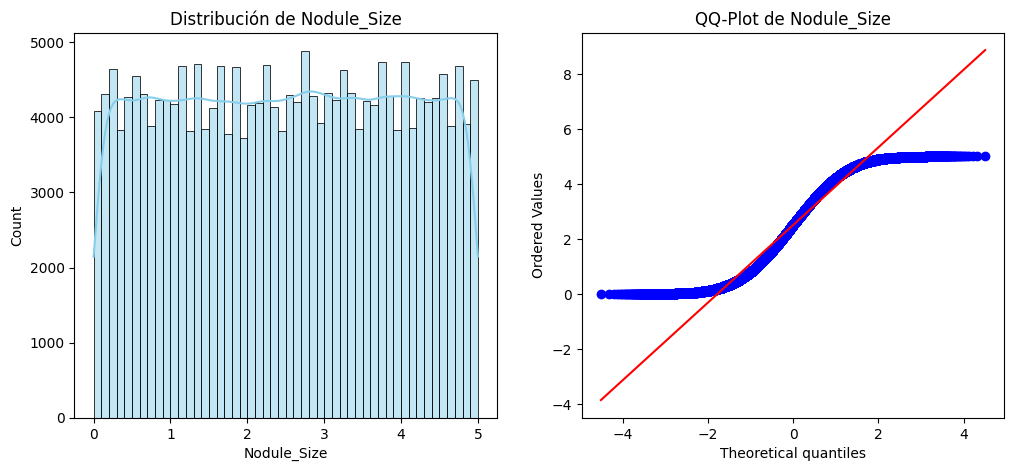


Pruebas de normalidad para: Nodule_Size
Shapiro-Wilk Test: p-valor = 0.00000
Kolmogorov-Smirnov Test: p-valor = 0.00000
Anderson-Darling Test: Estadístico = 2367.91611
  Al nivel de significancia 15.0%, los datos NO parecen normales.
  Al nivel de significancia 10.0%, los datos NO parecen normales.
  Al nivel de significancia 5.0%, los datos NO parecen normales.
  Al nivel de significancia 2.5%, los datos NO parecen normales.
  Al nivel de significancia 1.0%, los datos NO parecen normales.
D'Agostino-Pearson Test: p-valor = 0.00000


In [ ]:
#Función para calcular pruebas de normalidad.
def pruebas_normalidad(datos, nombre_columna):
  print(f"\nPruebas de normalidad para: {nombre_columna}")

  #Cálculo de Shapiro-Wilk.
  shapiro_test = stats.shapiro(datos.sample(min(5000, len(datos)), random_state=42))
  print(f"Shapiro-Wilk Test: p-valor = {shapiro_test.pvalue:.5f}")

  #Cálculo de Kolmogorov-Smirnov.
  ks_test = stats.kstest(datos, 'norm', args=(datos.mean(), datos.std()))
  print(f"Kolmogorov-Smirnov Test: p-valor = {ks_test.pvalue:.5f}")

  #Cálculo de Anderson-Darling.
  anderson_test = stats.anderson(datos, dist='norm')
  print(f"Anderson-Darling Test: Estadístico = {anderson_test.statistic:.5f}")
  for i in range(len(anderson_test.critical_values)):
    sl, cv = anderson_test.significance_level[i], anderson_test.critical_values[i]
    if anderson_test.statistic < cv:
      print(f"  Al nivel de significancia {sl}%, los datos parecen normales.")
    else:
      print(f"  Al nivel de significancia {sl}%, los datos NO parecen normales.")

  #Cálculo de D'Agostino-Pearson.
  dagostino_test = stats.normaltest(datos)
  print(f"D'Agostino-Pearson Test: p-valor = {dagostino_test.pvalue:.5f}")

#Función para crear gráficos.
def graficos(datos, nombre_columna):
  plt.figure(figsize=(12, 5))

  #Creación y diseño del histograma.
  plt.subplot(1, 2, 1)
  sns.histplot(datos, bins=50, kde=True, color="skyblue")
  plt.title(f"Distribución de {nombre_columna}")

  #Creación y diseño del QQplot.
  plt.subplot(1, 2, 2)
  stats.probplot(datos, dist="norm", plot=plt)
  plt.title(f"QQ-Plot de {nombre_columna}")

  plt.show()

#Crear gráficos y calcular pruebas de normalidad por columna.
for columna in columnas_numericas:
    datos = df[columna]
    graficos(datos, columna)
    pruebas_normalidad(datos, columna)

<ipython-input-94-f15e54f1054b>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=columna, data=df, palette='viridis')
<ipython-input-94-f15e54f1054b>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=columna, data=df, palette='viridis')
<ipython-input-94-f15e54f1054b>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=columna, data=df, palette='viridis')
<ipython-input-94-f15e54f1054b>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set 

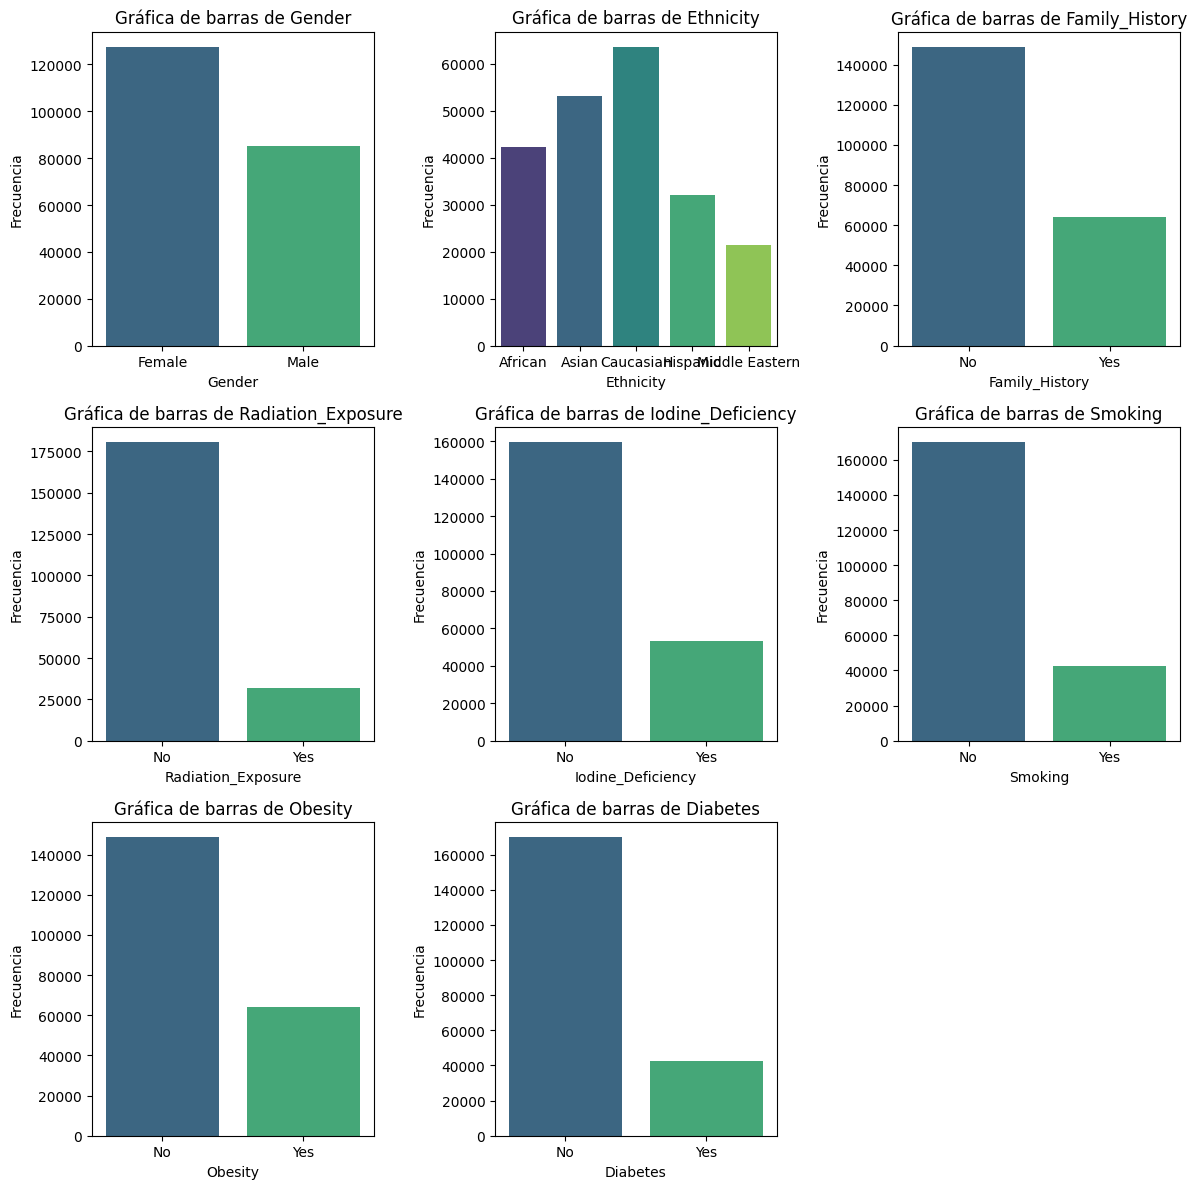

In [ ]:
columnascat = ['Gender', 'Ethnicity', 'Family_History', 'Radiation_Exposure', 'Iodine_Deficiency', 'Smoking', 'Obesity', 'Diabetes']

#Creación y diseño de los histogramas.
plt.figure(figsize=(12, 12))
for i, columna in enumerate(columnascat, 1):
  plt.subplot(3, 3, i)
  sns.countplot(x=columna, data=df, palette='viridis')
  plt.title(f'Gráfica de barras de {columna}')
  plt.ylabel('Frecuencia')

#Impresión de los gráficos.
plt.tight_layout()
plt.show()

# **6. Análisis Predictivo**

## - Preprocesamiento para Análisis Predictivo: Problemas, Técnicas y Código

## - Modelado Predictivo
### - Modelo elegido y parámetros
### - Entrenamiento y Evaluación
## - Resultados


# **7. Conclusiones y Trabajos Futuros**

## - Resumen del trabajo realizado, hallazgos y posibles mejoras